This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch internet, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU&feature=youtu.be&t=15m38s) at 15:36 or in [here](https://habrahabr.ru/post/275429/) **but in 2D**. You can google, search code at github, whatever, but the network should be based on TensoFlow.

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver` plot). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
init = tf.initializers.random_uniform(-1,1)

In [3]:
def discriminator(inpt, reuse):
    with tf.variable_scope("Discriminator", reuse=reuse):
        dl1 = tf.layers.dense(inpt,  20, activation=tf.nn.sigmoid, name="dl1", kernel_initializer=init)
        dl2 = tf.layers.dense( dl1, 100, activation=tf.nn.sigmoid, name="dl2", kernel_initializer=init)
        dl3 = tf.layers.dense( dl2,  20, activation=tf.nn.sigmoid, name="dl3", kernel_initializer=init)
        dis = tf.layers.dense( dl3,   1, name="dis")
        prob= tf.sigmoid(dis)
    return dis, prob

In [4]:
inX = tf.placeholder(tf.float32, shape=[None, 1], name="X")
y   = tf.placeholder(tf.float32, shape=[None, 1], name="target")

dis, dis_prob = discriminator(inX, False)

In [5]:
z  = tf.placeholder(tf.float32, shape=[None, 1], name="z")

with tf.variable_scope("Generator"):

    gl1 = tf.layers.dense(z,   20, activation=tf.nn.relu, name="gl1", kernel_initializer=init)
    gl2 = tf.layers.dense(gl1,100, activation=tf.nn.relu, name="gl2", kernel_initializer=init)
    gl3 = tf.layers.dense(gl1, 20, activation=tf.nn.relu, name="gl3", kernel_initializer=init)
    gen = tf.layers.dense(gl2,  1, name="gen")
    
_, prob_combined = discriminator(gen, True)

In [6]:
gen_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Discriminator")

In [7]:
dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis, labels=y))
gloss = -prob_combined

In [9]:
writer = tf.summary.FileWriter('log/')

In [10]:
writer.add_graph(tf.get_default_graph())

In [11]:
writer.close()

In [12]:
train_gen = tf.train.AdadeltaOptimizer().minimize(gloss, var_list=gen_vars)
train_dis = tf.train.AdadeltaOptimizer(learning_rate=0.1).minimize(dloss, var_list=disc_vars)

In [13]:
data = np.random.normal(-5, 1, size=(10000,1))

In [14]:
if "sess" in dir():
    sess.close()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
def generate_data_for_dist(batch_size):
    assert batch_size%2 == 0
    
    real_data = np.random.choice(data[:,0], (batch_size//2, 1))
    generated_data = sess.run(gen, feed_dict={z: np.random.uniform(-10,10,size=(batch_size//2,1))})
    
    y = np.zeros((batch_size, 1))
    y[batch_size//2:] = 1
    return np.concatenate((real_data, generated_data)),y

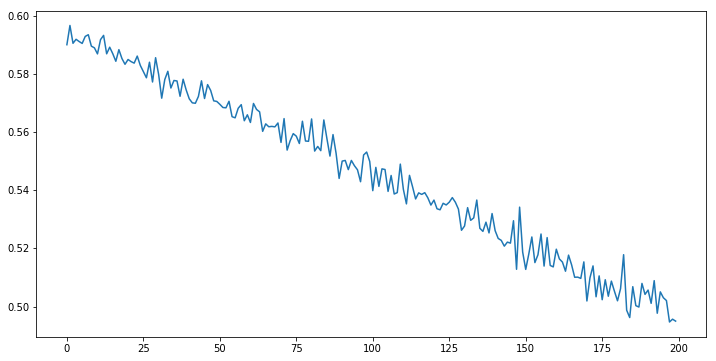

0.49500605


In [16]:
num_epochs = 200
batch_size = 100

losshist=[]

for epoch in range(num_epochs):
    
    X, Y = generate_data_for_dist(batch_size)
    
    _, dis_train_err = sess.run([train_dis, dloss], feed_dict={inX: X, y: Y})
    
    losshist.append(dis_train_err)
    clear_output(wait=True)
    plt.figure(figsize=(12,6))
    plt.plot(losshist)
    plt.show()
    print(dis_train_err)


In [17]:
l = np.linspace(-30,20,100)[None].T

In [18]:
out = sess.run(dis, feed_dict={inX: l})

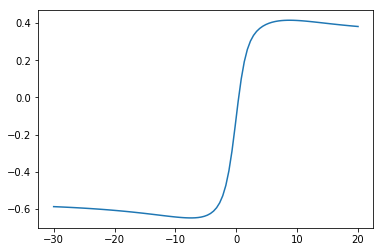

In [19]:
plt.plot(l,out);

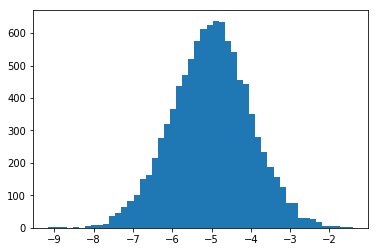

In [34]:
plt.hist(data, bins=50);